# Import the dataset

In [1]:
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 960.9 kB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [kagglehub]


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

/home/wandy/improc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


# Visualize the dataset
Samples two random images per class

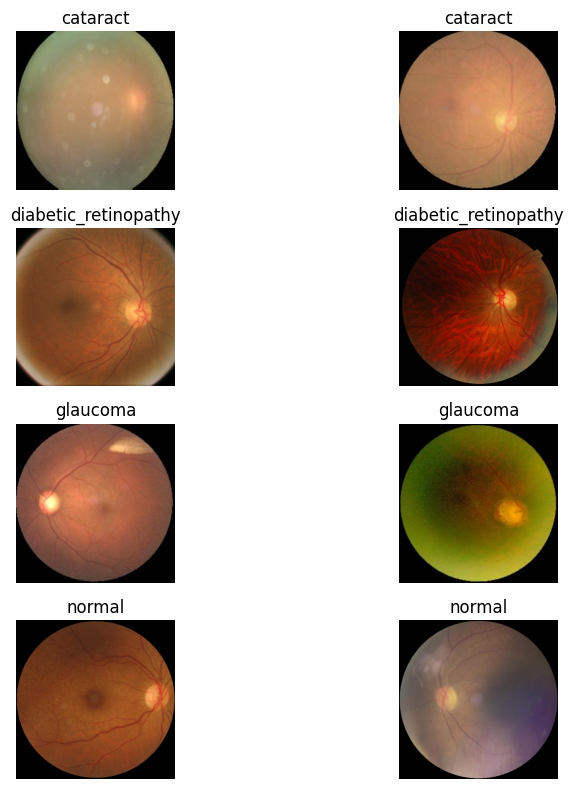

In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Folder names (classes)
CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Dictionary to store sampled file paths
sampled_images = {}

# Randomly pick 2 images per class
for cls in CLASSES:
    folder_path = os.path.join(path,"dataset", cls)
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sampled = random.sample(all_images, 2)
    sampled_images[cls] = [os.path.join(folder_path, img) for img in sampled]

# Display the sampled images
plt.figure(figsize=(10, 8))

idx = 1
for cls, img_paths in sampled_images.items():
    for img_path in img_paths:
        plt.subplot(4, 2, idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()


# Splitting the Dataset
Data was split into train, test, and val with the composition 70% - 15% - 15%

In [5]:
import os
import shutil
import random

SOURCE = "/home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset"
DEST = "/home/wandy/improc/UAS/dataset_split"

CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Create destination folders
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST, split, cls), exist_ok=True)

# Perform the split
for cls in CLASSES:
    src_folder = os.path.join(SOURCE, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    n = len(images)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)  # 70% + 15% = 85%

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "train", cls))

    for f in val_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "val", cls))

    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "test", cls))

print("Dataset successfully split into train, val, test!")


Dataset successfully split into train, val, test!


In [4]:
DEST = "/home/wandy/improc/UAS/dataset_split"

splits = ["train", "val", "test"]

print("\nSplit Dataset Counts:")
split_totals = {"train": 0, "val": 0, "test": 0}

for split in splits:
    print(f"\n[{split.upper()}]")
    for cls in CLASSES:
        folder = os.path.join(DEST, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
        split_totals[split] += count
        print(f"{cls}: {count}")

print("\nTOTALS:")
for split in splits:
    print(f"{split}: {split_totals[split]}")

print(f"\nGRAND TOTAL (train + val + test): {sum(split_totals.values())}")



Split Dataset Counts:

[TRAIN]
cataract: 726
diabetic_retinopathy: 768
glaucoma: 704
normal: 751

[VAL]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 151
normal: 161

[TEST]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 152
normal: 162

TOTALS:
train: 2949
val: 633
test: 635

GRAND TOTAL (train + val + test): 4217


# Import Libraries
Import all libraries needed for the model to ease the process

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model

from tensorflow.keras.applications import (
    ResNet50, DenseNet121, EfficientNetB3,
    Xception, InceptionV3, MobileNetV2
)

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_prep
from tensorflow.keras.applications.densenet import preprocess_input as dense_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_prep
from tensorflow.keras.applications.xception import preprocess_input as xcep_prep
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_prep
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_prep

from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import pandas as pd
import time
import os


2025-12-07 20:15:14.292187: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 20:15:14.654176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 20:15:16.690099: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import cv2

img = cv2.imread("./dataset_split/train/diabetic_retinopathy/10007_left.jpeg")
height, width, _ = img.shape
print(f"Image Resolution: {width} x {height} pixels")

Image Resolution: 512 x 512 pixels


In [3]:
DATASET_DIR = "/home/wandy/improc/UAS/dataset_split/"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20

In [4]:
def create_generators(img_size, preprocess_func):
    train_aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        preprocessing_function=preprocess_func
    )

    val_aug = ImageDataGenerator(preprocessing_function=preprocess_func)

    train_gen = train_aug.flow_from_directory(
        DATASET_DIR + "/train",
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode="sparse"
    )

    val_gen = val_aug.flow_from_directory(
        DATASET_DIR + "/val",
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode="sparse"
    )

    test_gen = val_aug.flow_from_directory(
        DATASET_DIR + "/test",
        target_size=(img_size, img_size),
        batch_size=32,
        shuffle=False,
        class_mode="sparse"
    )

    return train_gen, val_gen, test_gen


In [5]:
def train_and_evaluate(model_name, base_model, preprocess_func, img_size):

    print(f"\n🔵 Training {model_name} ...")

    # Load generators
    train_gen, val_gen, test_gen = create_generators(img_size, preprocess_func)
    num_classes = 4

    # Build model
    base_model.trainable = False
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)

    # Stage 1: Train head
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    start = time.time()
    model.fit(train_gen, validation_data=val_gen, epochs=6, verbose=1)

    # Stage 2: Fine-tune
    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(train_gen, validation_data=val_gen, epochs=6, verbose=1)
    end = time.time()

    # Evaluation
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)

    acc = (y_true == y_pred).mean()
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Macro F1": f1,
        "Time (min)": round((end - start) / 60, 2),
        "Confusion Matrix": cm
    }


In [6]:
models_to_test = [
    ("ResNet50", ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), resnet_prep, 224),
    ("DenseNet121", DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3)), dense_prep, 224),
    ("EfficientNetB3", EfficientNetB3(weights="imagenet", include_top=False, input_shape=(300,300,3)), eff_prep, 300),
    ("Xception", Xception(weights="imagenet", include_top=False, input_shape=(299,299,3)), xcep_prep, 299),
    ("InceptionV3", InceptionV3(weights="imagenet", include_top=False, input_shape=(299,299,3)), inc_prep, 299),
    ("MobileNetV2", MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), mob_prep, 224),
]


I0000 00:00:1765113319.850071   74967 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 37s 1us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 75s 2us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 170s 2us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 112s 1us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


In [ ]:
results = []
detailed_results = {}   # store confusion matrix, etc.

for name, base, prep, size in models_to_test:
    output = train_and_evaluate(name, base, prep, size)
    results.append({
        "Model": output["Model"],
        "Accuracy": output["Accuracy"],
        "Macro F1": output["Macro F1"],
        "Time (min)": output["Time (min)"]
    })
    detailed_results[name] = output   # store full info



🔵 Training ResNet50 ...
Found 2949 images belonging to 4 classes.
Found 633 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Epoch 1/6


2025-12-07 20:22:19.778419: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ff0d0001a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-07 20:22:19.778469: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-07 20:22:19.934279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-07 20:22:21.226321: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-07 20:22:21.861956: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5205', 8 bytes spill stores, 8 bytes spill loads



 2/93 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.2734 - loss: 2.1312  

I0000 00:00:1765113746.461555   75497 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.3733 - loss: 1.5412

2025-12-07 20:23:01.443865: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1698', 8 bytes spill stores, 8 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 469ms/step - accuracy: 0.4279 - loss: 1.3800 - val_accuracy: 0.5577 - val_loss: 0.9881
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 329ms/step - accuracy: 0.5619 - loss: 1.0516 - val_accuracy: 0.6698 - val_loss: 0.8148
Epoch 3/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 305ms/step - accuracy: 0.6267 - loss: 0.8966 - val_accuracy: 0.6682 - val_loss: 0.7645
Epoch 4/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 295ms/step - accuracy: 0.6558 - loss: 0.8259 - val_accuracy: 0.7030 - val_loss: 0.7014
Epoch 5/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 287ms/step - accuracy: 0.6921 - loss: 0.7563 - val_accuracy: 0.7093 - val_loss: 0.6871
Epoch 6/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.6965 - loss: 0.7587 - val_accuracy: 0.7220 - val_loss: 0.6803
Epoch 1/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 51s 390ms/step - accuracy: 0.7063 - loss: 0.7604 - val_accuracy: 0.6477 - val_loss: 0.9129
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 296ms/step - accuracy: 0.7837 - loss: 0.5518 - val_accuracy: 0.7820 - val

2025-12-07 20:28:59.651838: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12271', 8 bytes spill stores, 8 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2791 - loss: 1.9824

2025-12-07 20:29:53.203210: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3304', 8 bytes spill stores, 8 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 647ms/step - accuracy: 0.2821 - loss: 1.8326 - val_accuracy: 0.3128 - val_loss: 1.3606
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.3737 - loss: 1.5000 - val_accuracy: 0.4724 - val_loss: 1.1623
Epoch 3/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 292ms/step - accuracy: 0.4622 - loss: 1.3187 - val_accuracy: 0.5276 - val_loss: 1.0540
Epoch 4/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.4903 - loss: 1.2195 - val_accuracy: 0.5719 - val_loss: 0.9895
Epoch 5/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 307ms/step - accuracy: 0.5463 - loss: 1.1184 - val_accuracy: 0.6272 - val_loss: 0.9048
Epoch 6/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.5666 - loss: 1.0331 - val_accuracy: 0.6414 - val_loss: 0.8610
Epoch 1/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 593ms/step - accuracy: 0.5714 - loss: 1.0586 - val_accuracy: 0.7014 - val_loss: 0.7848
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 309ms/step - accuracy: 0.6412 - loss: 0.9053 - val_accuracy: 0.7267 - val

2025-12-07 20:37:07.392433: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:37:07.527381: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:37:07.676112: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:37:12.388252: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:37:12.541941: E external/local_xla/xla/stream_

27/93 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.2282 - loss: 1.4224

2025-12-07 20:37:56.646030: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:37:56.900581: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:37:57.183171: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:37:57.353179: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[5,816,19,19]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,816,19,19]{3,2,1,0}, f32[816,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, featur

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.3048 - loss: 1.3692

2025-12-07 20:38:51.169209: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:38:51.309459: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:38:51.419834: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:38:51.540219: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:38:56.152814: E external/local_xla/xla/stream_

93/93 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.3811 - loss: 1.2984 - val_accuracy: 0.5671 - val_loss: 1.1167
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.5805 - loss: 1.0562 - val_accuracy: 0.6240 - val_loss: 0.9836
Epoch 3/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 414ms/step - accuracy: 0.6538 - loss: 0.9232 - val_accuracy: 0.6288 - val_loss: 0.9046
Epoch 4/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 405ms/step - accuracy: 0.6823 - loss: 0.8410 - val_accuracy: 0.6414 - val_loss: 0.8551
Epoch 5/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 408ms/step - accuracy: 0.6843 - loss: 0.7952 - val_accuracy: 0.6588 - val_loss: 0.8208
Epoch 6/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 414ms/step - accuracy: 0.7111 - loss: 0.7409 - val_accuracy: 0.6667 - val_loss: 0.7937
Epoch 1/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 97s 737ms/step - accuracy: 0.6745 - loss: 0.8734 - val_accuracy: 0.6698 - val_loss: 0.7827
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 429ms/step - accuracy: 0.7389 - loss: 0.7306 - val_accuracy: 0.7220 - val_l

2025-12-07 20:47:37.156132: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:47:37.274464: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:47:41.750678: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:47:41.901104: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:47:42.054663: E external/local_xla/xla/stream_

20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step 

🔵 Training Xception ...
Found 2949 images belonging to 4 classes.
Found 633 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Epoch 1/6


2025-12-07 20:48:04.523154: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:48:04.686908: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:48:04.843461: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:48:05.004241: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:48:05.150927: E external/local_xla/xla/stream_

66/93 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - accuracy: 0.2076 - loss: 1.4905

2025-12-07 20:48:57.717982: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:48:57.851911: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:48:58.030356: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:48:59.872927: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:49:00.117176: E external/local_xla/xla/stream_

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.2272 - loss: 1.4646

2025-12-07 20:49:35.518716: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:49:35.681509: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:49:35.843826: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:49:36.004033: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:49:36.151480: E external/local_xla/xla/stream_

93/93 ━━━━━━━━━━━━━━━━━━━━ 115s 958ms/step - accuracy: 0.3015 - loss: 1.3768 - val_accuracy: 0.5261 - val_loss: 1.2234
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - accuracy: 0.5381 - loss: 1.1282 - val_accuracy: 0.6335 - val_loss: 1.0645
Epoch 3/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - accuracy: 0.6226 - loss: 0.9873 - val_accuracy: 0.6746 - val_loss: 0.9684
Epoch 4/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 431ms/step - accuracy: 0.6660 - loss: 0.9048 - val_accuracy: 0.6856 - val_loss: 0.9077
Epoch 5/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - accuracy: 0.6935 - loss: 0.8388 - val_accuracy: 0.6840 - val_loss: 0.8693
Epoch 6/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 423ms/step - accuracy: 0.7002 - loss: 0.8092 - val_accuracy: 0.7014 - val_loss: 0.8336
Epoch 1/6


2025-12-07 20:53:35.342447: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:53:35.531072: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:53:35.731825: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:53:35.920737: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:53:36.544430: W external/local_xla/xla/tsl/fra

93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 663ms/step - accuracy: 0.5378 - loss: 1.0741 - val_accuracy: 0.7188 - val_loss: 0.7645
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.6785 - loss: 0.7855 - val_accuracy: 0.7188 - val_loss: 0.7228
Epoch 3/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 421ms/step - accuracy: 0.7616 - loss: 0.6444 - val_accuracy: 0.7330 - val_loss: 0.6582
Epoch 4/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 431ms/step - accuracy: 0.7999 - loss: 0.5523 - val_accuracy: 0.7551 - val_loss: 0.6094
Epoch 5/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.8257 - loss: 0.4898 - val_accuracy: 0.7836 - val_loss: 0.5509
Epoch 6/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 428ms/step - accuracy: 0.8389 - loss: 0.4584 - val_accuracy: 0.8041 - val_loss: 0.5184
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step

2025-12-07 20:58:31.859818: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:58:32.011397: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:58:32.159031: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:58:33.779006: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-07 20:58:33.994573: E external/local_xla/xla/stream_

20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step 

🔵 Training InceptionV3 ...
Found 2949 images belonging to 4 classes.
Found 633 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Epoch 1/6


2025-12-07 20:59:12.131872: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 20 bytes spill stores, 24 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 88s 757ms/step - accuracy: 0.3835 - loss: 1.3267 - val_accuracy: 0.6114 - val_loss: 1.0308
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.5429 - loss: 1.0413 - val_accuracy: 0.6588 - val_loss: 0.8924
Epoch 3/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 424ms/step - accuracy: 0.6246 - loss: 0.9064 - val_accuracy: 0.6698 - val_loss: 0.8222
Epoch 4/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 410ms/step - accuracy: 0.6728 - loss: 0.8239 - val_accuracy: 0.6872 - val_loss: 0.7846
Epoch 5/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step - accuracy: 0.6680 - loss: 0.7969 - val_accuracy: 0.6904 - val_loss: 0.7731
Epoch 6/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 445ms/step - accuracy: 0.6874 - loss: 0.7632 - val_accuracy: 0.6888 - val_loss: 0.7568
Epoch 1/6


2025-12-07 21:04:02.225664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 20 bytes spill stores, 24 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 71s 583ms/step - accuracy: 0.6473 - loss: 0.8311 - val_accuracy: 0.6430 - val_loss: 0.7982
Epoch 2/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 51s 547ms/step - accuracy: 0.7213 - loss: 0.6723 - val_accuracy: 0.6840 - val_loss: 0.7096
Epoch 3/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 662ms/step - accuracy: 0.7759 - loss: 0.5890 - val_accuracy: 0.7299 - val_loss: 0.6651
Epoch 4/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 56s 597ms/step - accuracy: 0.7786 - loss: 0.5577 - val_accuracy: 0.7378 - val_loss: 0.6369
Epoch 5/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 51s 546ms/step - accuracy: 0.8037 - loss: 0.5216 - val_accuracy: 0.7567 - val_loss: 0.5959
Epoch 6/6
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 480ms/step - accuracy: 0.8135 - loss: 0.4939 - val_accuracy: 0.7646 - val_loss: 0.5824
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 911ms/step

🔵 Training MobileNetV2 ...
Found 2949 images belonging to 4 classes.
Found 633 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Epoch 1/6


In [ ]:
leaderboard = pd.DataFrame(results).sort_values(by="Macro F1", ascending=False)
leaderboard


In [ ]:
def summarize_models(detailed_results):
    print("\n========== MODEL SUMMARY ==========\n")
    for name, data in detailed_results.items():
        print(f"Model: {name}")
        print(f"  Accuracy     : {data['Accuracy']:.4f}")
        print(f"  Macro F1     : {data['Macro F1']:.4f}")
        print(f"  Train Time   : {data['Time (min)']} min")
        print(f"  Confusion Matrix:\n{data['Confusion Matrix']}")
        print("----------------------------------")
summarize_models(detailed_results)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 46s 248ms/step - accuracy: 0.5710 - loss: 1.0694 - val_accuracy: 0.6761 - val_loss: 0.7875 - learning_rate: 1.0000e-05
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.7487 - loss: 0.6482 - val_accuracy: 0.7646 - val_loss: 0.6077 - learning_rate: 1.0000e-05
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - accuracy: 0.8003 - loss: 0.5313 - val_accuracy: 0.8073 - val_loss: 0.5525 - learning_rate: 1.0000e-05
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.8328 - loss: 0.4426 - val_accuracy: 0.8231 - val_loss: 0.4739 - learning_rate: 1.0000e-05
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.8549 - loss: 0.3926 - val_accuracy: 0.8357 - val_loss: 0.4657 - learning_rate: 1.0000e-05
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - accuracy: 0.8600 - loss: 0.3633 - val_accuracy: 0.8578 - val_loss: 0.4283 - learning_rate: 1.0000e-05
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 31s 16